In [119]:
import statsmodels.formula.api as smf
import statsmodels.regression.rolling as rolling
import statsmodels.api as sm
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import numpy as np
import pandas as pd

# Load and clean data

In [120]:
two_year = pl.read_parquet('data/two_year.parquet')
equities = pl.read_parquet('data/equities.parquet')

In [121]:
# Merge
df = two_year.join(equities, on=['date'], how='inner')

# Filter
df = (
    df.filter(
        pl.col('date').is_between(date(1993, 1, 29), date.today())
    )
    .sort('date')
)

# Yield level change
df = df.with_columns(
    pl.col('yield').diff().mul(100).alias('yield_level_change')
)

# ETF Return
df = df.with_columns(
    pl.col('close').truediv(pl.col('open')).sub(1).mul(100).over('ticker').alias('ret')
)

# Drop columns
df = df.drop(['ticker', 'open', 'close'])

# Drop nulls
df = df.drop_nulls()

df

date,yield,yield_level_change,ret
date,f64,f64,f64
1993-02-01,4.19,-1.0,0.639659
1993-02-02,4.25,6.0,0.282686
1993-02-03,4.27,2.0,0.914849
1993-02-04,4.19,-8.0,0.069493
1993-02-05,4.07,-12.0,0.0
…,…,…,…
2025-02-05,4.17,-4.0,0.596024
2025-02-06,4.21,4.0,0.054459
2025-02-07,4.29,8.0,-1.008419


# Summary Statistics

In [122]:
display(
    df.select('yield_level_change').describe(),
    df.select('ret').describe()
)

statistic,yield_level_change
str,f64
"""count""",8001.0
"""null_count""",0.0
"""mean""",0.001125
"""std""",5.571254
"""min""",-57.0
"""25%""",-3.0
"""50%""",0.0
"""75%""",3.0
"""max""",38.0


statistic,ret
str,f64
"""count""",8001.0
"""null_count""",0.0
"""mean""",0.005535
"""std""",0.954426
"""min""",-8.990574
"""25%""",-0.415901
"""50%""",0.04603
"""75%""",0.4662
"""max""",9.296296


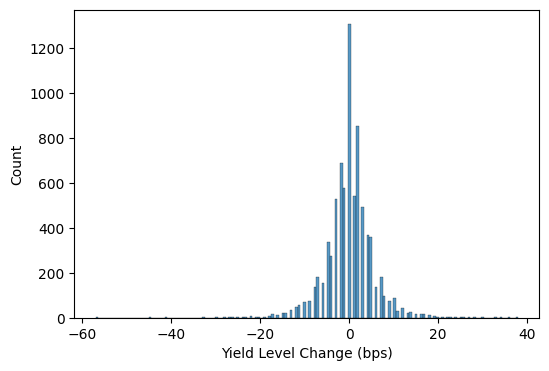

In [123]:
plt.figure(figsize=(6, 4))
sns.histplot(df, x='yield_level_change')
plt.xlabel("Yield Level Change (bps)")
plt.show()

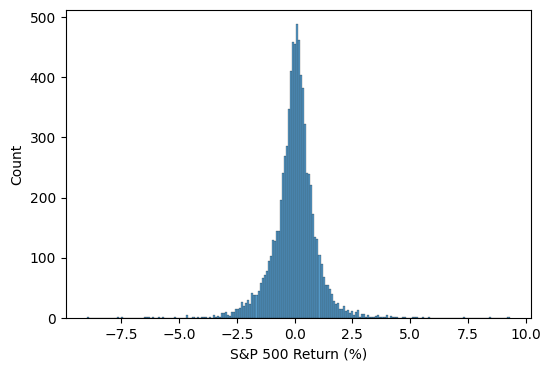

In [124]:
plt.figure(figsize=(6, 4))
sns.histplot(df, x='ret')
plt.xlabel("S&P 500 Return (%)")
plt.show()

# Regression functions

In [125]:
def regression_summary(df: pl.DataFrame, x: str | list[str], y: str) -> None:
    x_list = x if isinstance(x, list) else [x]
    formula = f"{y} ~ {' + '.join(x_list)}"
    model = smf.ols(formula=formula, data=df)
    result = model.fit()
    print(result.summary())

In [126]:
def regression_line(df: pl.DataFrame, x: str, y: str) -> tuple[np.array, np.array]:
    # Regression results
    formula = f"{y} ~ {x}"
    result = smf.ols(formula=formula, data=df).fit()

    # Regression line
    intercept, slope = result.params['Intercept'], result.params[x]
    x = np.linspace(df[x].min(), df[x].max())
    y = [intercept + slope * x for x in x]

    return x, y

# Plot functions

In [127]:
def plot_regression_scatter(df: pl.DataFrame, x: str, y: str, regression_line: tuple[np.array, np.array]) -> None:
    x_data, y_data = regression_line

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x], df[y], s=10)
    plt.plot(x_data, y_data, color='red')

    plt.title("Effect of Short Term Yield Changes on Market Returns")
    plt.ylabel("S&P 500 Daily Return (%)")
    plt.xlabel("Daily 2 Year Yield Level Change (bps)")
    
    plt.show()

In [128]:

def rolling_regression(df: pl.DataFrame, x: str | list[str], y: str, window: int = 250 * 5) -> pd.DataFrame:
    x_list = x if isinstance(x, list) else [x]

    rolling_df = df.to_pandas()

    # Add constant for intercept
    rolling_df['const'] = 1

    # Fit Rolling OLS
    model = rolling.RollingOLS(rolling_df[y], sm.add_constant(rolling_df[x_list]), window=window)
    results = model.fit()

    # Get rolling coefficients
    for x in x_list:
        rolling_df[f'{x}_coefficient'] = results.params[x]
        rolling_df[f'{x}_t_stat'] = results.tvalues[x]
    
    rolling_df['intercept_coefficient'] = results.params['const']
    rolling_df['intercept_t_stat'] = results.tvalues['const']

    rolling_df = rolling_df.dropna().reset_index(drop=True)

    rolling_df = rolling_df.drop(columns=['const'])

    return rolling_df

In [129]:
def plot_rolling_results(
        rolling_df: pd.DataFrame, 
        variable: str,
    ) -> None:
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Sub plots
    sns.lineplot(ax=axes[0], data=rolling_df, x='date', y=f"{variable}_coefficient", label=f"{variable.replace('_', '-').title()} Coefficient")
    sns.lineplot(ax=axes[1], data=rolling_df, x='date', y=f"{variable}_t_stat", label=f"{variable.replace('_', '-').title()} T-stat")

    # Title
    fig.suptitle("Rolling 5 Year Regression")

    # Remove legends
    axes[0].legend().set_visible(False)
    axes[1].legend().set_visible(False)
    
    # Sub titles
    axes[0].set_title(f"{variable.replace('_', '-').title()} Coefficient")
    axes[1].set_title(f"{variable.replace('_', '-').title()} T-Stat")
    
    # Labels
    axes[0].set_xlabel(None)
    axes[0].set_ylabel(None)

    axes[1].set_xlabel(None)
    axes[1].set_ylabel(None)

    # Lines
    axes[0].axhline(y=0, color='k', ls='--')

    axes[1].axhline(y=-2, color='k', ls='--')    
    axes[1].axhline(y=2, color='k', ls='--')    

    plt.show()

# Standard Results

In [130]:
regression_summary(
    df=df,
    x='yield_level_change',
    y='ret'
)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     104.4
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           2.29e-24
Time:                        22:45:58   Log-Likelihood:                -10927.
No. Observations:                8001   AIC:                         2.186e+04
Df Residuals:                    7999   BIC:                         2.187e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0055      0

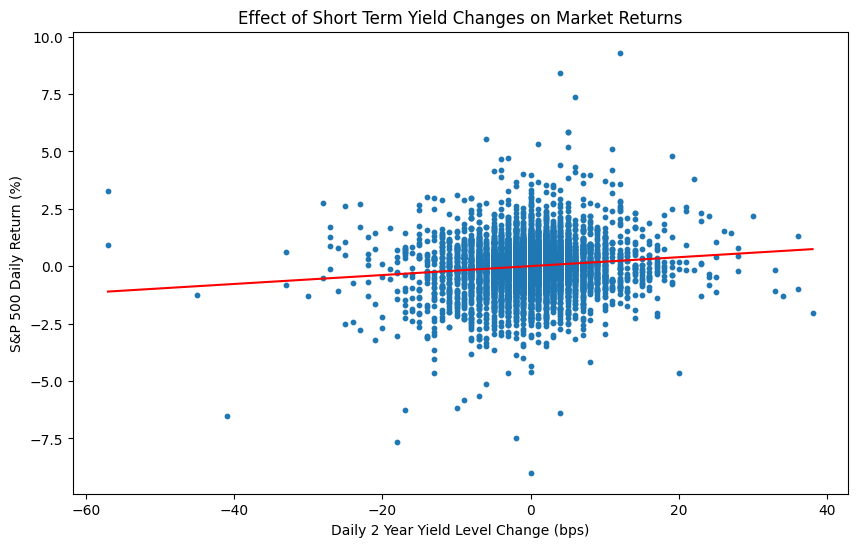

In [131]:
reg_line = regression_line(
    df=df,
    x='yield_level_change',
    y='ret'  
)

plot_regression_scatter(
    df=df,
    x='yield_level_change',
    y='ret',
    regression_line=reg_line
)

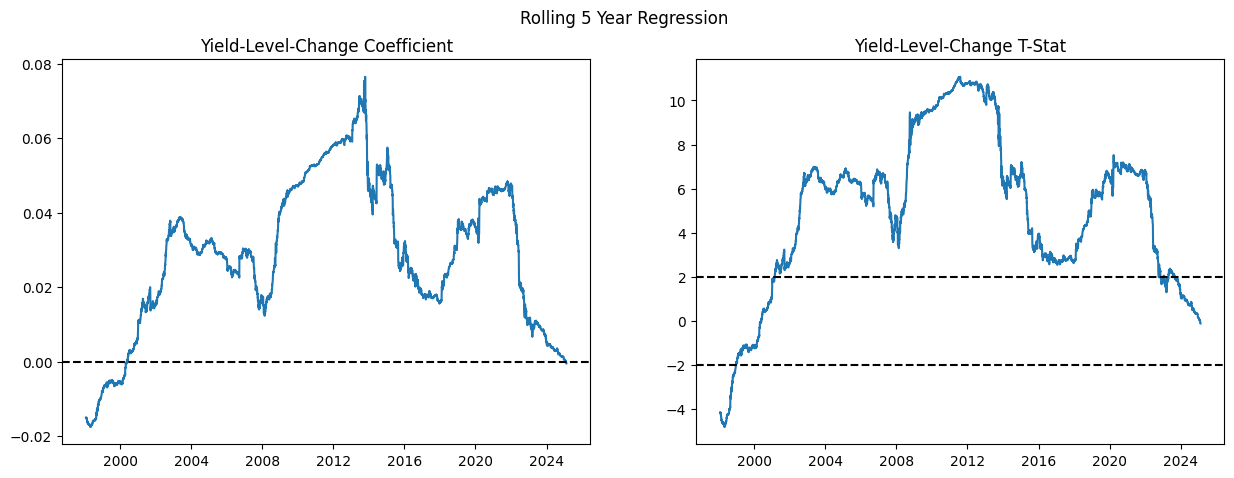

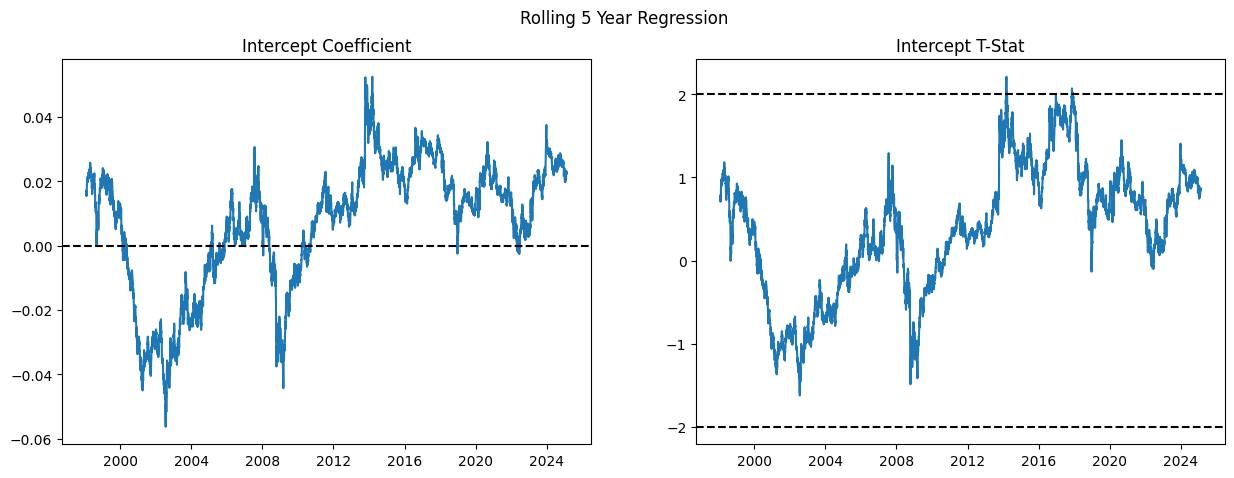

In [132]:
rolling_df = rolling_regression(
    df=df,
    x='yield_level_change',
    y='ret'
)

plot_rolling_results(
    rolling_df=rolling_df,
    variable='yield_level_change',
)

plot_rolling_results(
    rolling_df=rolling_df,
    variable='intercept',
)

# Results with Conditioning on Market Trends

In [133]:
# Create rolling 5 year return variable
window = 252
df = (
    df
    .with_columns(
        pl.col('ret')
        .truediv(100)
        .log1p()
        .alias('log_ret')
    )
    .with_columns(
        pl.col('log_ret')
        .rolling_sum(window_size=window, min_samples=window)
        .exp()
        .sub(1)
        .mul(100)
        .alias('ret_5y')
    )
    .with_columns(
        pl.when(
            pl.col('ret_5y') >= 0
        )
        .then(
            pl.lit(1)
        )
        .otherwise(
            pl.lit(0)
        )
        .alias('growth_dummy')
    )
    .filter(pl.col('ret_5y').is_not_null())
)

df

date,yield,yield_level_change,ret,log_ret,ret_5y,growth_dummy
date,f64,f64,f64,f64,f64,i32
1994-02-01,4.2,8.0,-0.389358,-0.003901,-3.212409,0
1994-02-02,4.2,0.0,0.324675,0.003241,-3.515336,0
1994-02-03,4.28,8.0,-0.259403,-0.002597,-4.036894,0
1994-02-04,4.42,14.0,-2.275683,-0.02302,-7.070871,0
1994-02-07,4.41,-1.0,0.733823,0.007311,-6.453944,0
…,…,…,…,…,…,…
2025-02-05,4.17,-4.0,0.596024,0.005943,-0.17208,0
2025-02-06,4.21,4.0,0.054459,0.000544,-1.050794,0
2025-02-07,4.29,8.0,-1.008419,-0.010135,-2.979886,0


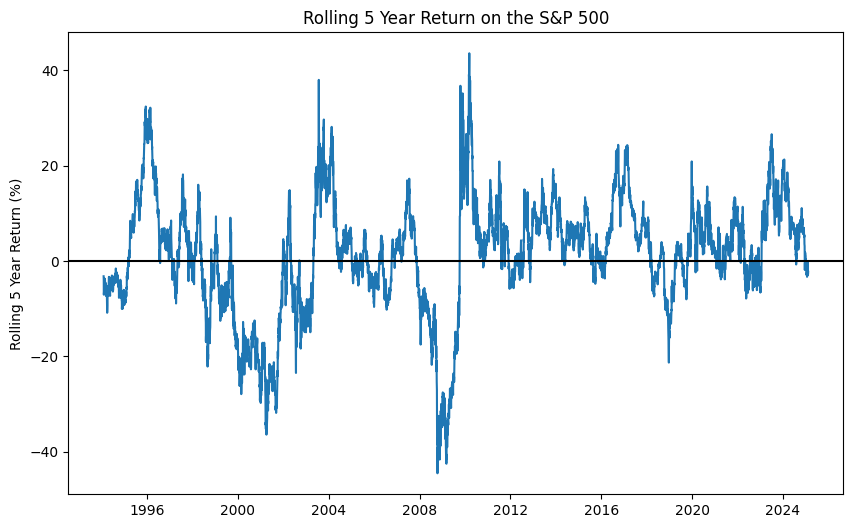

In [134]:
plt.figure(figsize=(10, 6))
sns.lineplot(df, x='date', y='ret_5y')
plt.axhline(0, c='k')
plt.title('Rolling 5 Year Return on the S&P 500')
plt.ylabel('Rolling 5 Year Return (%)')
plt.xlabel(None)
plt.show()

In [135]:
formula = "ret ~ yield_level_change + growth_dummy"
result = smf.ols(formula, df).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     62.83
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           8.52e-28
Time:                        22:45:59   Log-Likelihood:                -10662.
No. Observations:                7750   AIC:                         2.133e+04
Df Residuals:                    7747   BIC:                         2.135e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0523      0.017     -3.041      0.002      -0.086      -0.019
yield_level_change     0.0200      0.002     10.268      0.000       0.016       0.024
growth_dummy           0.0972      0.022      4.377      0.000       0.054       0.141
==============================================================================
Omnibus:                     1153.273   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18776.343
Skew:                          -0.025   Prob(JB):                         0.00
Kurtosis:                      10.625   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

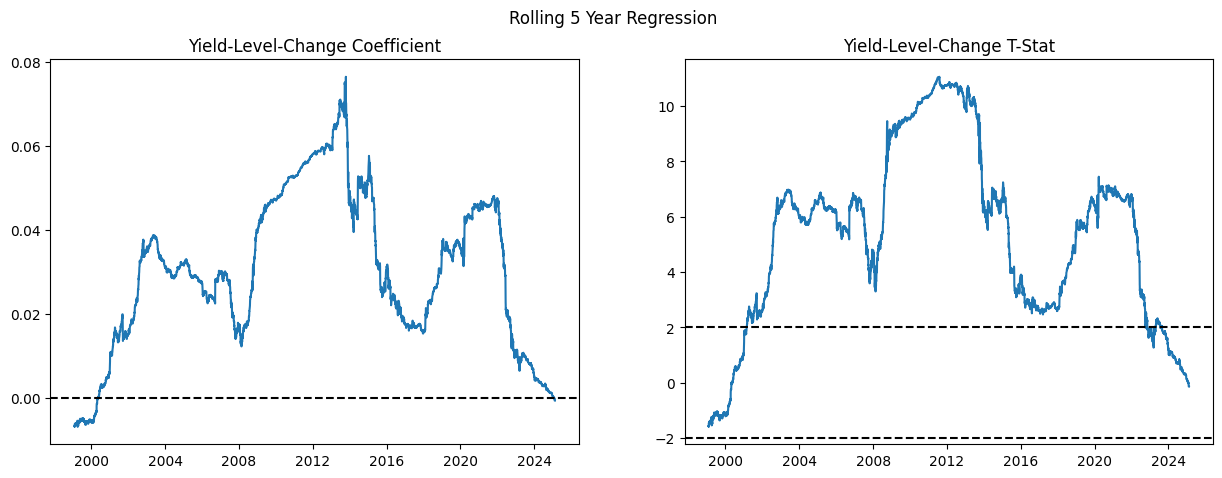

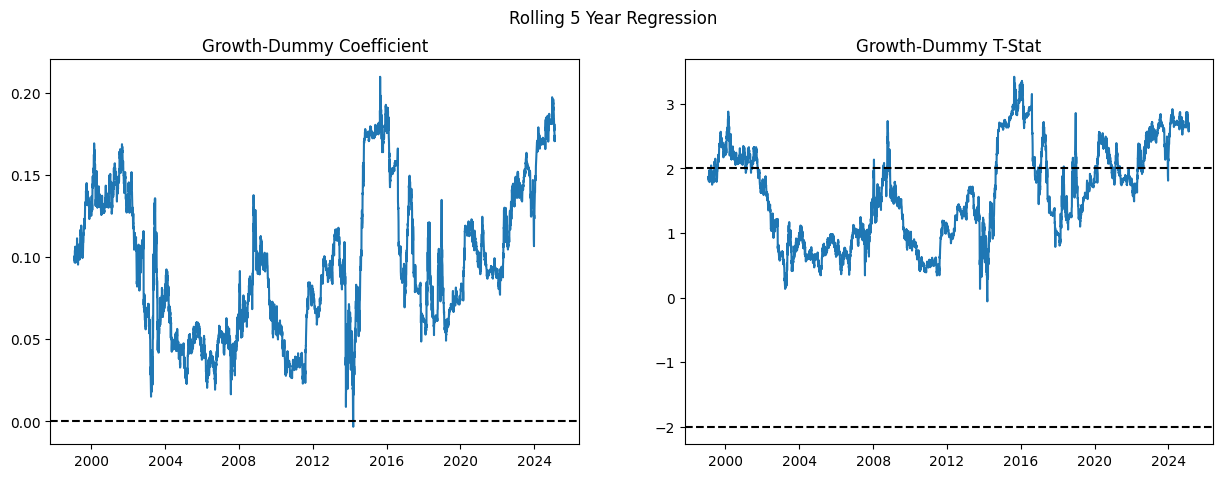

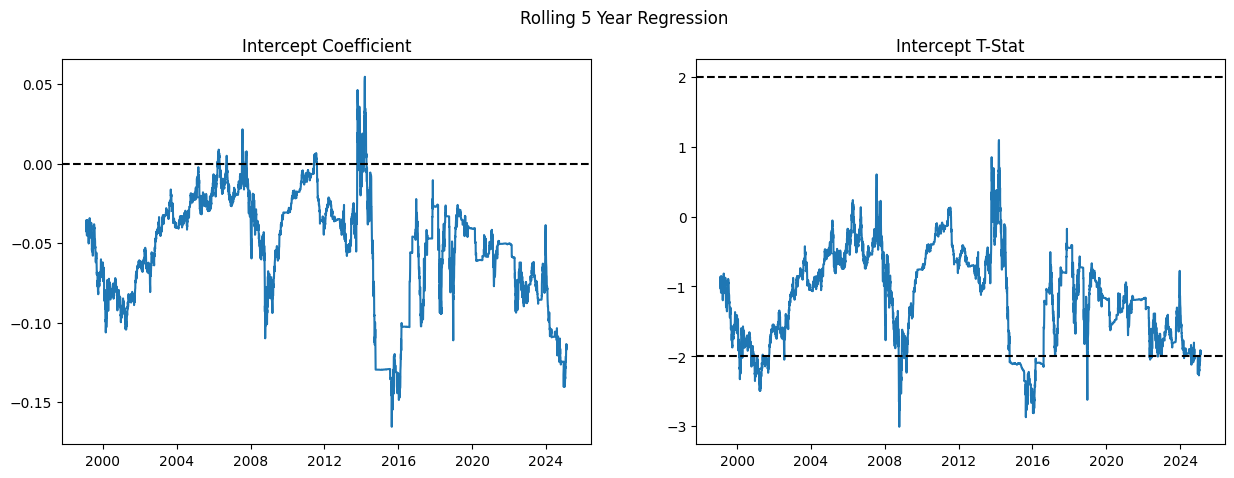

In [136]:
rolling_df_2 = rolling_regression(
    df, 
    x=['yield_level_change', 'growth_dummy'], 
    y='ret'
)

plot_rolling_results(
    rolling_df=rolling_df_2,
    variable='yield_level_change',
)

plot_rolling_results(
    rolling_df=rolling_df_2,
    variable='growth_dummy',
)

plot_rolling_results(
    rolling_df=rolling_df_2,
    variable='intercept',
)

In [137]:
regression_summary(
    df,
    x=['yield_level_change', 'growth_dummy'],
    y='ret'
)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     62.83
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           8.52e-28
Time:                        22:45:59   Log-Likelihood:                -10662.
No. Observations:                7750   AIC:                         2.133e+04
Df Residuals:                    7747   BIC:                         2.135e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0523      0